### Setup


In [9]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import random

env = gym.make('CliffWalking-v0')

#Ref: pseudo codes from Sutton book and inspiration of graphs from https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/cliff_walking.py 


### Parent class for temporal difference algorithms
- this part captures the common steps of different TD algorithms

In [2]:
class TemporalDifference:
  def __init__(self, epsilon = 0.1, max_steps = 70, alpha = 0.5, gamma = 1, total_episode = 500, no_run = 101):
    self.epsilon, self.max_steps, self.alpha, self.gamma, self.total_episode = epsilon, max_steps, alpha, gamma, total_episode
    self.no_run = list(range(1,no_run))
    

  #Function to choose the next action
  def choose_action(self, Q, state):
      if np.random.uniform(0, 1) < self.epsilon:
          action = env.action_space.sample()
      else:
          action = np.argmax(Q[state, :])
      return action

  def learning(self, learning_algorithm):
    #Initializing the Q-matrix and sum of rewards per episode
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    total_optimal_rewards = np.zeros(self.total_episode)

    # Starting learning
    for i in self.no_run: 
      for episode in range(self.total_episode):
        t = 0
        state1 = env.reset() 
        action1 = self.choose_action(Q, state1)
        done = False

        while t < self.max_steps and not done:
          #Getting the next state
          state2, reward, done, info = env.step(action1)
          action2 = self.choose_action(Q, state2) #the difference between SARSA and Q-Learning

          #Learning the Q-value
          Q = learning_algorithm(Q, state1, state2, reward, action1, action2)

          state1 = state2
          action1 = action2
            
          #Updating timestep
          t += 1

        #run one episode with the epsilon-greedy policy with the learnt Q
        t_optimal = 0
        state1 = env.reset() 
        done = False
        optimal_reward = 0
        while t_optimal < self.max_steps and not done:
          action1 = self.choose_action(Q, state1)
          state2, reward, done, info = env.step(action1)
          state1= state2
          t_optimal += 1
          optimal_reward += reward

        total_optimal_rewards[episode] += optimal_reward
    return Q, total_optimal_rewards          

  # find best policy using the latest Q value
  def best_policy(self, Q):
    policy = np.argmax(Q, axis = -1)
    actions = ["^", ">", "v", "<"]
    policy_arrows = [actions[i] for i in policy]
    return pd.DataFrame(np.array(policy_arrows).reshape(4,12))
    

  def __repr__(self): #for description of object
    return f"Sarsa({self.epsilon}, {self.max_steps}, {self.alpha}, {self.gamma}, {self.total_episode}, {len(self.no_run)})"
  

### Subclasses for SARSA and Q-Learning algorithms
- this part captures the different parts of different TD algorithms

In [3]:
class Sarsa(TemporalDifference):
  #Function to learn the Q-value for a SARSA agent
  def update_Q(self, Q, state, state2, reward, action, action2):
      predict = Q[state, action]
      target = reward + self.gamma * Q[state2, action2]
      Q[state, action] = Q[state, action] + self.alpha * (target - predict)
      Q[47, :] = 0
      return Q

  def learning(self):
    print("Sarsas learning")
    return super().learning(self.update_Q)



In [4]:
class Q_Learning(TemporalDifference):
  #Function to learn the Q-value for a Q-Learning agent
  def update_Q(self, Q, state, state2, reward, action, *args):
      predict = Q[state, action]
      action_best = np.argmax(Q[state2,:], axis = -1)
      target = reward + self.gamma * Q[state2, action_best]
      Q[state, action] = Q[state, action] + self.alpha * (target - predict)
      Q[47, :] = 0
      return Q

  def learning(self):
    print("Q-Learning learning")
    return super().learning(self.update_Q)

### Monte Carlo Method (with Exploring Start)

In [14]:
class MonteCarlo:
  def __init__(self, epsilon = 0.1, max_steps = 70, total_episode = 500, no_run = 101):
    self.epsilon, self.max_steps, self.total_episode = epsilon, max_steps, total_episode
    self.no_run = list(range(1,no_run))

  #choose action with epsilon greedy policy
  def choose_action(self, Q, state):
    if np.random.uniform(0, 1) < self.epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action

  def play(self, Q): 
    t = 0
    state1 = env.reset() 
    done = False
    optimal_reward = 0

    while t < self.max_steps and not done:
      action1 = self.choose_action(Q, state1)
      state2, reward, done, info = env.step(action1)
      state1= state2
      t += 1
      optimal_reward += reward
    return optimal_reward

  def learning(self):
    #initialize the Q-matrix 
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    #intialize a random policy
    policy = []
    for i in range(0,48):
      n = random.randint(0,3)
      policy.append(n)
    #create an empty list to store returns for state-action pairs
    G = np.zeros((env.observation_space.n, env.action_space.n))
    #create an empty list to store the no. of times a state-action pair has been visited
    N = np.zeros((env.observation_space.n, env.action_space.n))
    total_optimal_rewards = np.zeros(self.total_episode)

    for i in self.no_run: 
      for episode in range(self.total_episode):
        t = 0
        state1 = random.randint(0,47) 
        action = random.randint(0,3)
        done = False
        episode_return = 0
        #record the starting point of this episode
        first_state  = state1
        first_action = action

        #generate an episode
        while t < self.max_steps and not done:
            prob, state2, reward, done = env.P[state1][action][0]
            episode_return += reward
            state1 = state2
            action = policy[state2]
            #Updating timestep
            t += 1
        
        #update Q at the end of an episode
        N[first_state][first_action] += 1 
        G[first_state][first_action] += episode_return
        Q[first_state][first_action] = G[first_state][first_action]/N[first_state][first_action]

        #update policy at the end of an episode
        policy = np.argmax(Q, axis = -1)

        #play the game once for evaluation
        optimal_reward = self.play(Q)
        total_optimal_rewards[episode] += optimal_reward
      
    return Q, total_optimal_rewards  
  
  # find best policy using the latest Q value
  def best_policy(self, Q):
    policy = np.argmax(Q, axis = -1)
    actions = ["^", ">", "v", "<"]
    policy_arrows = [actions[i] for i in policy]
    return pd.DataFrame(np.array(policy_arrows).reshape(4,12))
  

### Training and getting best policy

In [16]:
#create a sarsa agent object
s1 = Sarsa()
#learning
Q, total_optimal_rewards_sarsa = s1.learning()
#best policy after learning
s1.best_policy(Q)



Sarsas learning


,0,1,2,3,4,5,6,7,8,9,10,11
0,>,>,>,>,>,>,>,>,>,v,v,>
1,>,^,^,^,>,>,>,^,^,>,>,v
2,^,^,^,^,^,^,^,^,^,^,>,v
3,^,^,^,^,^,^,^,^,^,^,^,^


In [17]:
#create a Q-learning agent object
q1 = Q_Learning()
#learning
Q, total_optimal_rewards_q = q1.learning()
#best policy after learning
q1.best_policy(Q)

Q-Learning learning


,0,1,2,3,4,5,6,7,8,9,10,11
0,v,>,>,>,>,>,>,>,>,>,>,v
1,>,>,>,>,>,>,>,>,>,>,>,v
2,>,>,>,>,>,>,>,>,>,>,>,v
3,^,^,^,^,^,^,^,^,^,^,^,^


In [15]:
#create a MC agent object
m1 = MonteCarlo()
#learning
Q, total_optimal_rewards_m = m1.learning()
#best policy after learning
m1.best_policy(Q)

,0,1,2,3,4,5,6,7,8,9,10,11
0,>,>,>,>,v,>,>,>,v,>,v,v
1,>,>,>,>,>,>,>,>,>,v,v,v
2,>,^,>,^,^,^,>,>,>,>,>,v
3,^,^,^,^,^,^,^,^,^,^,>,>


### Comparison between MC,TD algorithms

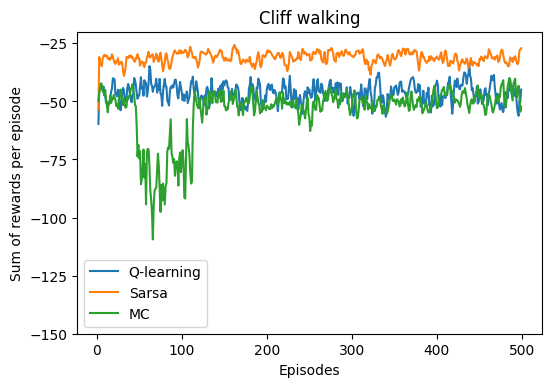

In [19]:
fig = plt.figure(dpi=100)
ax = plt.axes()
all_matrix = np.array([total_optimal_rewards_q, total_optimal_rewards_sarsa, total_optimal_rewards_m]).transpose()
df = pd.DataFrame(all_matrix, columns = ["Q-learning", "Sarsa", "MC"])
df["Q-learning"] /= 100
df["Sarsa"] /= 100
df["MC"] /= 100
df['MA_Q-learning'] = df["Q-learning"].rolling(window=3).mean()
df['MA_Sarsa'] = df["Sarsa"].rolling(window=3).mean()
df['MA_MC'] = df["MC"].rolling(window=3).mean()

ax = sns.lineplot(data=df, x = df.index, y = "MA_Q-learning")
ax = sns.lineplot(data=df, x = df.index, y = "MA_Sarsa")
ax = sns.lineplot(data=df, x = df.index, y = "MA_MC")
ax.set(title="Cliff walking", xlabel="Episodes", ylabel = "Sum of rewards per episode", yticks = range(-150, -20, 25))
ax.set_ylim(-150,-20)
ax.legend(["Q-learning", "Sarsa", "MC"])